In [1]:
import numpy as np
import os
import usleep
import typing

from IPython.display import clear_output

In [2]:
# ARGS

class ARGS(object):
    def __init__(self, file, data_per_prediction: int = 128):
        self.f = os.path.abspath(file) if not os.path.isabs(file) else file
        self.o = self.f.replace(".edf",".npy")
        self.logging_out_path = self.f.replace(".edf",".log")
        
        self.auto_channel_grouping =  ['EOG', 'EEG']
        self.auto_reference_types  =  None
        self.channels              =  ['O1-M2==EEG', 'O2-M1==EEG', 'E1-M1==EOG', 'E2-M1==EOG']
        self.data_per_prediction   =  128
        self.force_gpus            =  ''
        self.header_file_name      =  None
        self.model                 =  'u-sleep:1.0'
        self.no_argmax             =  True
        self.num_gpus              =  0
        self.overwrite             =  True
        self.project_dir           =  usleep.get_model_path(model_name=self.model.split(":")[0], model_version=self.model.split(":")[-1])
        self.strip_func            =  'trim_psg_trailing'
        self.weights_file_name     =  None

In [3]:
from utime import Defaults
from utime.hyperparameters import YAMLHParams

# Load arguments and hyperparamets
args = ARGS(file="edf_data/9JQY.edf", data_per_prediction=128)
hparams = YAMLHParams(Defaults.get_hparams_path(args.project_dir), no_version_control=True)


In [4]:
from psg_utils.dataset.sleep_study import SleepStudy
from utime.bin.predict_one import get_sleep_study

def get_and_load_study(file, args: ARGS, hparams: YAMLHParams) -> SleepStudy:

    # Get the sleep study
    print(f"Loading and pre-processing PSG file {file}...")
    hparams['prediction_params']['channels'] = args.channels
    hparams['prediction_params']['strip_func']['strip_func_str'] = args.strip_func

    study, channel_groups = get_sleep_study(psg_path=file,
                                            header_file_name=args.header_file_name,
                                            auto_channel_grouping=args.auto_channel_grouping,
                                            auto_reference_types=args.auto_reference_types,
                                            **hparams['prediction_params'])
    
    study.channel_groups = channel_groups

    return study

## Initialize model to train


In [5]:
from utime.bin.evaluate import get_and_load_model, get_and_load_one_shot_model
from keras import Model
from keras.layers import Input

# Initialize model to train
hparams = YAMLHParams(Defaults.get_hparams_path(args.project_dir), no_version_control=True)
hparams['build']['batch_shape'] = [64, 19, 3840, 2]

base = get_and_load_model(
            project_dir=args.project_dir,
            hparams=hparams,
            weights_file_name=hparams.get('weights_file_name')
        )
clear_output(wait=False)    # Removing glorot intitialization warning...

# Freeze base layers
base.trainable = False

base.layers[-5].trainable = True

# Extract base from pre-trained model (remove last )
inter_base = Model(inputs=base.input, outputs=base.layers[-5].output, name="uSleep_base")
inter_out = inter_base(inputs=base.input, training=False)

# Create new head with base model as input with a 2-class problem
head=base.create_seq_modeling(in_=inter_out,
                            input_dims = base.input_dims,
                            data_per_period=args.data_per_prediction,
                            n_periods=base.n_periods,
                            n_classes=2,
                            transition_window=base.transition_window,
                            activation=base.activation,
                            regularizer=None)


model = Model(inputs=base.input, outputs = head, name = "mU-Sleep")

print(f"Input shape: {model.input.shape}")
print(f"Output shape: {model.output.shape}")
print(f"Model trainable: {model.trainable}")
_=[print(f"\t {x.name}: ({x.shape})") for x in model.trainable_weights]
model.summary()


Input shape: (None, 19, 3840, 2)
Output shape: (None, 19, 30, 2)
Model trainable: True
	 dense_classifier_out/kernel:0: ((1, 1, 6, 6))
	 dense_classifier_out/bias:0: ((6,))
	 sequence_conv_out_1/kernel:0: ((1, 1, 6, 2))
	 sequence_conv_out_1/bias:0: ((2,))
	 sequence_conv_out_2/kernel:0: ((1, 1, 2, 2))
	 sequence_conv_out_2/bias:0: ((2,))
Model: "mU-Sleep"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 19, 3840, 2)]     0         
                                                                 
 uSleep_base (Functional)    (None, 72960, 1, 6)       3119286   
                                                                 
 average_pool (AveragePoolin  (None, 570, 1, 6)        0         
 g2D)                                                            
                                                                 
 sequence_conv_out_1 (Conv2D  (None, 570, 1, 2)

In [6]:
import json

# Load some random subjects from train splits
with open("./splits/skorucack_splits.json") as f:
    splits = json.loads(f.read())


dev_studies = [get_and_load_study(f"edf_data/{x}.edf", args, hparams) for x in splits['train']]
test_studies = [get_and_load_study(f"edf_data/{x}.edf", args, hparams) for x in splits['test']]
clear_output(wait=False)

In [7]:
# Let's add some random labels to the studies (for now)
from tensorflow import keras
from keras.utils.np_utils import to_categorical
from scipy.io import loadmat


for study in dev_studies:
    psg_shape = study.get_all_periods().shape
    _y = loadmat(study.psg_file_path.replace(".edf","_new.mat"), squeeze_me=True)['x']
    _y[np.where(_y != 1)[0]] = 0
    _y = to_categorical(_y, num_classes = 2)
    study.y = np.reshape(_y, [psg_shape[0], int(psg_shape[1] / study.sample_rate) , 2])
    
for study in test_studies:
    psg_shape = study.get_all_periods().shape
    _y = loadmat(study.psg_file_path.replace(".edf","_new.mat"), squeeze_me=True)['x']
    _y[np.where(_y != 1)[0]] = 0
    _y = to_categorical(_y, num_classes = 2)
    study.y = np.reshape(_y, [psg_shape[0], int(psg_shape[1] / study.sample_rate) , 2])
    

print(model.input.shape)
print(model.layers[-1].output.shape)
print(dev_studies[0].get_all_periods().shape)
print(dev_studies[0].y.shape)
all_studies = np.concatenate([np.array(dev_studies),np.array(test_studies)])


(None, 19, 3840, 2)
(None, 19, 30, 2)
(80, 3840, 4)
(80, 30, 2)


In [8]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Make stratified train/val splits based on recordings having any MS event

df_train = pd.DataFrame({"Name": splits['train'],
                        "MS": [np.any(s.y[...,1]==1) for s in dev_studies],
                        "n_periods": [x.n_periods for x in dev_studies],
                        "Studies": dev_studies})

_train, _val = train_test_split(df_train, test_size=0.2, stratify=df_train.MS, random_state=16)
train_studies = _train[_train.n_periods >= 0].Studies.tolist()
val_studies = _val[_val.n_periods >= 0].Studies.tolist()

# del [_train, _val, df_train, dev_studies]

In [9]:
# Save the validation split to be used for self-supervised learning
val_id = [s.psg_file_path.split("\\")[-1].replace(".edf","") for s in val_studies]
new_train = [id for id in splits['train'] if id not in val_id]
new_val = [id for id in splits['train'] if id in val_id]

skorucack_splits_with_validation = {"train": new_train,
                                   "valid": new_val,
                                   "test": splits['test']}

with open("splits\\new_skorucak_splits_with_validation.json", "w") as f:
    json.dump(skorucack_splits_with_validation, f)

In [10]:
train_pos = sum([np.sum(v.y[...,1]==1) for v in train_studies])/sum([np.prod(v.y[...,1].shape) for v in train_studies])
train_neg = 1 - train_pos
val_pos = sum([np.sum(v.y[...,1]==1) for v in val_studies])/sum([np.prod(v.y[...,1].shape) for v in val_studies])
val_neg = 1 - val_pos

print(f"Training {train_pos:.4f} are positive - Naive method baseline is: {train_neg:.4f}")
print(f"Validation {val_pos:.4f} are positive - Naive method baseline is: {val_neg:.4f}")

Training 0.1069 are positive - Naive method baseline is: 0.8931
Validation 0.0883 are positive - Naive method baseline is: 0.9117


In [11]:
import tensorflow as tf

# Create generator which extracts contigous intervals randomly from a random recording

class Generator(tf.keras.utils.Sequence):

    def __init__(self, studies: typing.List[SleepStudy], hparams: YAMLHParams):
        
        self.studies = studies
        self.params  = hparams
        self.batch_shape = hparams['build']['batch_shape']
        self.batch_size = self.batch_shape[0]
        self.period_size = self.batch_shape[1]
        self.n_classes = 2
        self.n_channels = 4
        self.margin = int(np.floor((self.period_size / 2))) #if self.period_size % 2 else int(self.period_size / 2) - 1
        self.num_entries = sum([(x.get_all_periods().shape[0] - self.margin*2) * x.n_channels for x in studies])

        # Init x and y
        self.indices = self._generate_indices()
        self.idx = np.arange(0, len(self.indices))
        self.x = self._get_x_data()
        self.y = self._get_y_data()

        np.random.shuffle(self.idx)
   
    def __len__(self):
        return int(np.floor(self.num_entries / self.batch_size))

    def __getitem__(self, index):
        inds = self.idx[index*self.batch_size:(index+1)*self.batch_size]
        batch_x = self.x[inds]
        batch_y = self.y[inds]
        return batch_x, batch_y
    
    def _generate_indices(self):
        num_pi=[x.n_periods - self.margin*2 for x in self.studies]
        idxs = []
        for s in range(len(self.studies)):
            for p in range(int(num_pi[s])):
                for c in range(self.n_channels):
                    idxs.append((s, p+self.margin, c))
        return idxs

    def _get_x_data(self): 
        
        def _get_psg_by_idx(s: SleepStudy, period, channel, margin):
            return s.get_all_periods()[period-margin:period+margin+1,...,s.channel_groups[channel].channel_indices]

        return np.array([_get_psg_by_idx(self.studies[i[0]], i[1], i[2], self.margin) for i in self.indices])
    
    def _get_y_data(self): 
        
        def _get_target_by_idx(s: SleepStudy, period, margin):
            return s.y[period-margin:period+margin+1, ...]

        return np.array([_get_target_by_idx(self.studies[i[0]], i[1], self.margin) for i in self.indices])
    
    def on_epoch_end(self):
        np.random.shuffle(self.idx)

val_data = Generator(val_studies, hparams)
train_data = Generator(train_studies, hparams)  


## Train only head (pre fine-tuning)

In [12]:
train_model = False
folder = "TL_17022023_validation_split"

if not os.path.exists(folder) and train_model:
    os.mkdir(folder)


In [13]:
from keras.callbacks import EarlyStopping
import pickle

epochs_pre = 30
# cb = [EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)]


if train_model:

    model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = tf.keras.metrics.CategoricalAccuracy())


    with tf.device("/device:GPU:0"):
        history = model.fit(train_data,
                            # validation_data=val_data, 
                            epochs=epochs_pre,
                            # callbacks=cb
                            )

    # Save training
    with open(f"{folder}\\history", 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
    
    model.save_weights(f"{folder}\\weights_new_pre.h5")


In [ ]:
# Unfreeze all model for fine-tuning and train for another 50 epochs

epochs_post = history.epoch[-1] + 70

if train_model:

    # Unfreeze for fine-tuning
    base.trainable = True

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-7),
                loss = tf.keras.losses.CategoricalCrossentropy(),
                metrics = tf.keras.metrics.CategoricalAccuracy())

    # cb = [EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)]

    with tf.device("/device:GPU:0"):
        history_fine = model.fit(train_data,
                                # validation_data=val_data, 
                                epochs=epochs_post,
                                initial_epoch=history.epoch[-1],
                                # callbacks=cb
                                )
    
    # Save fine-tune training
    model.save_weights(f"{folder}\\weights_new_post.h5")

    with open(f"{folder}\\history_fine", 'wb') as file_pi:
        pickle.dump(history_fine.history, file_pi)


## Analyze tranfer learning run and make test predictions
Files are stored in TL_17022023_validation_split

In [15]:
import pickle

with open(f"{folder}/history", "rb") as f:
    history_pre = pickle.load(f)

with open(f"{folder}/history_fine", "rb") as f:
    history_post = pickle.load(f)

history = dict.fromkeys(history_post.keys())
for (k, pre), (_, post) in zip(history_pre.items(), history_post.items()):
    history[k] = [*pre, *post]

history['epoch'] = np.arange(0, len(history[k]))
history['train_new'] = np.concatenate([np.repeat("pre", len(pre)), np.repeat("post",len(post))])

pred_weights = f"{folder}/weights_new_post.h5"


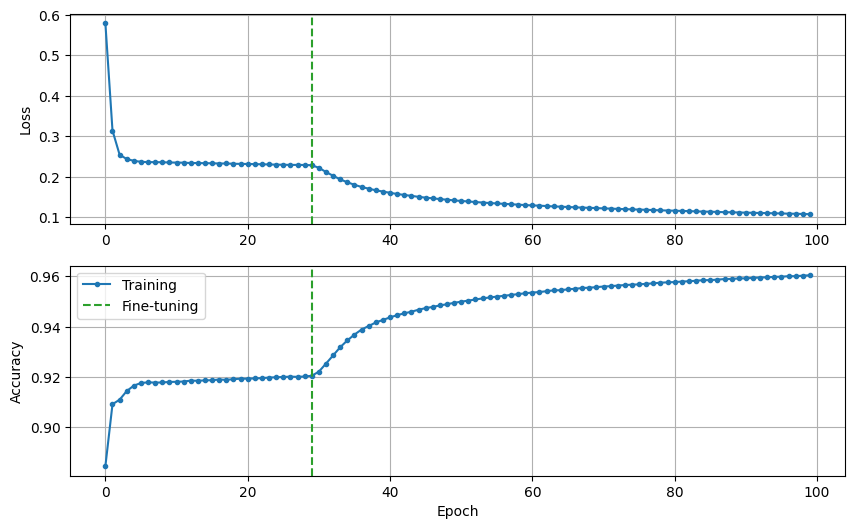

In [17]:
import matplotlib.pyplot as plt
# Plot learning curves
df = pd.DataFrame(history)
change = np.where(df.train_new=="pre")[0][-1]

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,6))
ax1.plot(df.epoch, df.loss, "-o", color="tab:blue", label="Train", markersize=3)
# ax1.plot(df.epoch, df.val_loss, "-o", color="tab:orange", label="Validation", markersize=3)
ax1.axvline(x=change, linestyle="--", color="tab:green", label="Fine-tuning")
ax1.set_ylabel("Loss")
ax1.grid()

ax2.plot(df.epoch, df.categorical_accuracy, "-o", color="tab:blue", label="Training", markersize=3)
# ax2.plot(df.epoch, df.val_categorical_accuracy, "-o", color="tab:orange", label="Validation", markersize=3)
ax2.axvline(x=change, linestyle="--", color="tab:green", label="Fine-tuning")
ax2.set_ylabel("Accuracy")
ax2.set_xlabel("Epoch")
ax2.legend()
ax2.grid()


In [18]:
# Create model for prediction

def load_prediction_model_for_study(study, weight_file, args, hparams):

    base = get_and_load_one_shot_model(
                n_periods=study.n_periods,
                project_dir=args.project_dir,
                hparams=hparams
                )
    clear_output(wait=False)    # Removing glorot intitialization warning...

    # Freeze base layers
    base.trainable = False

    base.layers[-5].trainable = True

    # Extract base from pre-trained model (remove last )
    inter_base = Model(inputs=base.input, outputs=base.layers[-5].output, name="uSleep_base")
    inter_out = inter_base(inputs=base.input, training=False)

    # Create new head with base model as input with a 2-class problem
    head=base.create_seq_modeling(in_=inter_out,
                                input_dims = base.input_dims,
                                data_per_period=args.data_per_prediction,
                                n_periods=base.n_periods,
                                n_classes=2,
                                transition_window=base.transition_window,
                                activation=base.activation,
                                regularizer=None)


    model = Model(inputs=base.input, outputs = head, name = "mU-Sleep")

    if weight_file is not None:
        model.trainable = True  # In order to load weights
        model.load_weights(weight_file)
        model.trainable = False
        

    print(f"Input shape: {model.input.shape}")
    print(f"Output shape: {model.output.shape}")
    print(f"Model trainable: {model.trainable}")
    _=[print(f"\t {x.name}: ({x.shape})") for x in model.trainable_weights]
    model.summary()

    return model

def predict_on_study(mdl, study: SleepStudy):

    prob = np.empty([len(study.channel_groups), study.n_periods*mdl.output_shape[-2], mdl.output_shape[-1]])
    for i, channel_group in enumerate(study.channel_groups):
        # Get PSG for particular group
        psg = np.expand_dims(study.get_all_periods(),0)
        psg_subset = psg[..., tuple(channel_group.channel_indices)]
        prob_i = mdl.predict_on_batch(psg_subset)
        prob[i,...] = prob_i.reshape(-1, prob.shape[-1])
    
    return prob


In [19]:


# Make validation predictions

ids = []
val_prob = []
val_y = []

for s in val_studies:

    pred_model = load_prediction_model_for_study(s, weight_file=pred_weights, args=args, hparams=hparams)

    prob = predict_on_study(pred_model, s)
    
    ids.append(s.identifier)
    val_prob.append(prob.mean(axis=0))
    val_y.append(s.y[...,1].flatten())
    


Input shape: (None, 80, 3840, 2)
Output shape: (None, 80, 30, 2)
Model trainable: False
Model: "mU-Sleep"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 3840, 2)]     0         
                                                                 
 uSleep_base (Functional)    (None, 307200, 1, 6)      3119286   
                                                                 
 average_pool (AveragePoolin  (None, 2400, 1, 6)       0         
 g2D)                                                            
                                                                 
 sequence_conv_out_1 (Conv2D  (None, 2400, 1, 2)       14        
 )                                                               
                                                                 
 sequence_conv_out_2 (Conv2D  (None, 2400, 1, 2)       6         
 )                                  

Best Threshold=0.200, F-Score=0.804, Recall=0.835, Precision=0.774


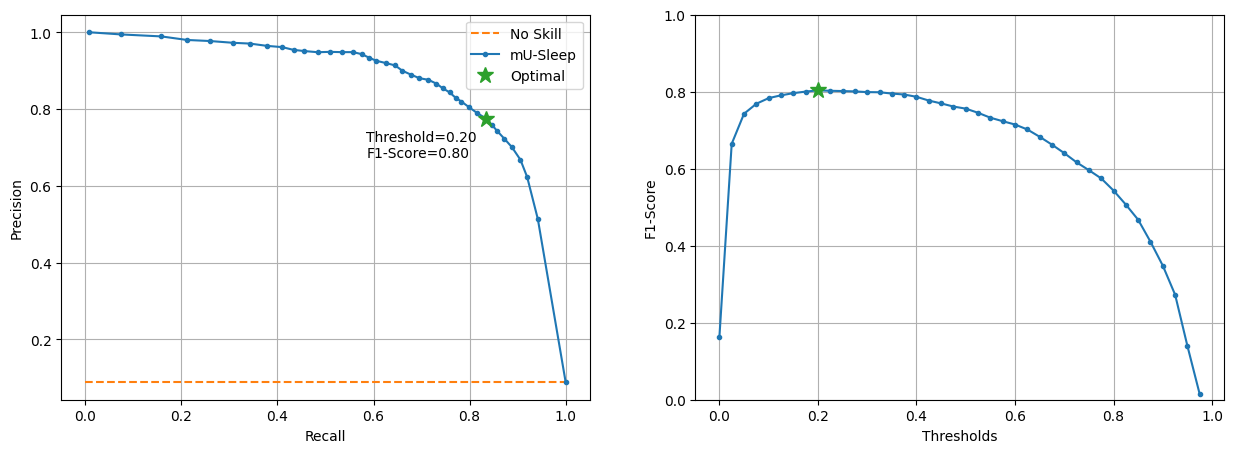

In [25]:
val_cat_y = np.concatenate(val_y)
val_cat_prob = np.concatenate(val_prob)

# pr curve for logistic regression model
from sklearn.metrics import precision_recall_curve, precision_score, recall_score

# calculate pr-curve
# precision, recall, thresholds = precision_recall_curve(val_cat_y, val_cat_prob[:,1])

thresholds = np.arange(start=0.0, stop=1.0, step=0.025)
precision = np.array([precision_score(val_cat_y, val_cat_prob[:,1] >= t) for t in thresholds])
recall = np.array([recall_score(val_cat_y, val_cat_prob[:,1] >= t) for t in thresholds])

# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
opt_idx = np.argmax(fscore)

# plot the roc curve for the model
no_skill = len(val_cat_y[val_cat_y==1]) / len(val_cat_y)
_, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
ax1.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill', color="tab:orange")
ax1.plot(recall, precision, marker='.', label='mU-Sleep', color="tab:blue")
ax1.plot(recall[opt_idx], precision[opt_idx], marker="*", color="tab:green", markersize=12, label="Optimal", linestyle="none")
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.legend()
ax1.grid()
info_txt = f"Threshold={thresholds[opt_idx]:.2f}\nF1-Score={fscore[opt_idx]:.2f}" 
ty = -0.1
tx = -0.25
ax1.text(recall[opt_idx]+tx, precision[opt_idx]+ty, info_txt)

# Plot F1-threshold curve
ax2.plot(thresholds, fscore, marker='.', color="tab:blue")
ax2.plot(thresholds[opt_idx], fscore[opt_idx], marker='*', markersize=12, color="tab:green", label="Optimal")
ax2.set_ylim([0,1])
ax2.grid()
ax2.set_xlabel("Thresholds")
ax2.set_ylabel("F1-Score")

print('Best Threshold=%.3f, F-Score=%.3f, Recall=%.3f, Precision=%.3f' % (thresholds[opt_idx], fscore[opt_idx], recall[opt_idx], precision[opt_idx]))


In [26]:
# Make test predictions

test_ids = []
test_prob = []
test_y = []

for s in test_studies:

    pred_model = load_prediction_model_for_study(s, weight_file=pred_weights, args=args, hparams=hparams)

    prob = predict_on_study(pred_model, s)
    
    test_ids.append(s.psg_file_path.split("\\")[-1].replace(".edf",""))
    test_prob.append(prob.mean(axis=0))
    test_y.append(s.y[...,1].flatten())
    


Input shape: (None, 38, 3840, 2)
Output shape: (None, 38, 30, 2)
Model trainable: False
Model: "mU-Sleep"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 38, 3840, 2)]     0         
                                                                 
 uSleep_base (Functional)    (None, 145920, 1, 6)      3119286   
                                                                 
 average_pool (AveragePoolin  (None, 1140, 1, 6)       0         
 g2D)                                                            
                                                                 
 sequence_conv_out_1 (Conv2D  (None, 1140, 1, 2)       14        
 )                                                               
                                                                 
 sequence_conv_out_2 (Conv2D  (None, 1140, 1, 2)       6         
 )                                  

In [27]:
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, cohen_kappa_score

y_cat_prob = np.concatenate(test_prob)
y_cat_true = np.concatenate(test_y)
y_pred = y_cat_prob[:,1] >= thresholds[opt_idx]

print(f"Confusion matrix:\n{confusion_matrix(y_cat_true, y_pred)}")
print(f"F1-Score:\t{f1_score(y_cat_true, y_pred)}")
print(f"Precision:\t{precision_score(y_cat_true, y_pred)}")
print(f"Recall:\t\t{recall_score(y_cat_true, y_pred)}")
# print(f"Cohen kappa:\t{cohen_kappa_score(y_cat_true, y_pred):.3f}")


Confusion matrix:
[[44950  1676]
 [  697  3407]]
F1-Score:	0.7417002285838685
Precision:	0.6702734605547904
Recall:		0.8301656920077972


In [28]:
# Save results to be used in Matlab

from scipy.io import savemat
# Write predictions to file
test_dict = {"id": test_ids,
            "probs": test_prob,
            "yTrue": test_y,
            "optThres": thresholds[opt_idx]}

savemat("Matlab/transfer_learning_new_with_validation.mat", test_dict)


c:\Users\Sindri\anaconda3\envs\u-sleep\lib\site-packages\scipy\io\matlab\_mio5.py:493: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  narr = np.asanyarray(source)


# Debug architecture changes


In [ ]:

# _base = get_and_load_one_shot_model(
#             n_periods=35,
#             project_dir=args.project_dir,
#             hparams=hparams
#             )
# clear_output(wait=False)    # Removing glorot intitialization warning...

# # Freeze base layers
# _base.trainable = False

# _base.layers[-5].trainable = True

# # Extract base from pre-trained model (remove last )
# _inter_base = Model(inputs=_base.input, outputs=_base.layers[-5].output, name="uSleep_base")
# _inter_out = _inter_base(inputs=_base.input, training=False)

# # Create new head with base model as input with a 2-class problem
# head=_base.create_seq_modeling(in_=_inter_out,
#                             input_dims = _base.input_dims,
#                             data_per_period=args.data_per_prediction,
#                             n_periods=_base.n_periods,
#                             n_classes=2,
#                             transition_window=_base.transition_window,
#                             activation=_base.activation,
#                             regularizer=None)


# _model = Model(inputs=_base.input, outputs = head, name = "mU-Sleep")

# # _model.trainable = True  # In order to load weights
# # _model.load_weights(pred_weights)
# # _model.trainable = False
    

# print(f"Input shape: {_model.input.shape}")
# print(f"Output shape: {_model.output.shape}")
# print(f"Model trainable: {_model.trainable}")
# _=[print(f"\t {x.name}: ({x.shape})") for x in _model.trainable_weights]
# _model.summary()


# Eval training data to check overfitting

In [29]:
train_ids = []
train_prob = []
train_y = []

for s in dev_studies:

    pred_model = load_prediction_model_for_study(s, weight_file=pred_weights, args=args, hparams=hparams)

    prob = predict_on_study(pred_model, s)
    
    train_ids.append(s.psg_file_path.split("\\")[-1].replace(".edf",""))
    train_prob.append(prob.mean(axis=0))
    train_y.append(s.y[...,1].flatten())

Input shape: (None, 80, 3840, 2)
Output shape: (None, 80, 30, 2)
Model trainable: False
Model: "mU-Sleep"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 3840, 2)]     0         
                                                                 
 uSleep_base (Functional)    (None, 307200, 1, 6)      3119286   
                                                                 
 average_pool (AveragePoolin  (None, 2400, 1, 6)       0         
 g2D)                                                            
                                                                 
 sequence_conv_out_1 (Conv2D  (None, 2400, 1, 2)       14        
 )                                                               
                                                                 
 sequence_conv_out_2 (Conv2D  (None, 2400, 1, 2)       6         
 )                                  

In [30]:
# Write predictions to file
train_dict = {"id": train_ids,
            "probs": train_prob,
            "yTrue": train_y,
            "optThres": thresholds[opt_idx]}

savemat("Matlab/training_performance//transfer_learning_new_with_validation.mat", train_dict)